In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm, expon
import pandas_datareader.data as web
import math
from tkinter import *
from tkinter import ttk

In [140]:
def ui():
    window = Tk()
    window.geometry("600x500")
    l1 = Label(window, text = "1. Stock Ticker (separate by comma).")
    l1.grid(row = 0, column = 0)
    l2 = Label(window, text = "2. shares ratio (separate by comma).")
    l2.grid(row = 2, column = 0)
    l3 = Label(window, text = "3. Initial Capital v0")    
    l3.grid(row = 4, column = 0)
    l4 = Label(window, text = "4. Risk Day")    
    l4.grid(row = 6, column = 0)
    l5 = Label(window, text = "5. years window")    
    l5.grid(row = 8, column = 0)
    l6 = Label(window, text = "6. P level")    
    l6.grid(row = 10, column = 0)
    l7 = Label(window, text = "Choose risk measure")    
    l7.grid(row = 0, column = 1)
    l8 = Label(window, text = "Choose type")    
    l8.grid(row = 2, column = 1)
    l9 = Label(window, text = "If Parametric, choose:")    
    l9.grid(row = 5, column = 1)
    l10 = Label(window, text = "If Monte Carlo, enter number of simulations N:")    
    l10.grid(row = 7, column = 1)
    l11 = Label(window, text = "If Historical, choose:")    
    l11.grid(row = 9, column = 1)
    
    
    
    stocks = StringVar()
    e1 = Entry(window, textvariable = stocks)
    e1.grid(row = 1,column = 0)
    stocks.set('msft,ba,jnj,ge,dis')
    
    shares = StringVar()
    e2 = Entry(window, textvariable = shares)
    e2.grid(row = 3,column = 0)
    shares.set('5,8,0,0,8')
    
    v0 = StringVar()
    e3 = Entry(window, textvariable = v0)
    e3.grid(row = 5,column = 0)
    v0.set('10000')
    
    risk_day = StringVar()
    e4 = Entry(window, textvariable = risk_day )
    e4.grid(row = 7,column = 0)
    risk_day.set('5')
    
    windows = StringVar()
    e5 = Entry(window, textvariable = windows )
    e5.grid(row = 9,column = 0)
    windows.set('5')
    
    p = StringVar()
    e6 = Entry(window, textvariable = p )
    e6.grid(row = 11,column = 0)
    p.set('0.99')
    
    m = StringVar()
    e7 = Entry(window, textvariable = m )
    e7.grid(row = 8,column = 1)
    m.set('1000')
    
    btn = Button(window, text = "save and close", command = window.destroy)
    btn.grid(row = 13, column = 1)
    
    risk_measure = StringVar()
    combo1 = ttk.Combobox(window, values = ['VaR', "ES"], textvariable = risk_measure)
    combo1.grid(row = 1,column = 1)
    combo1.current(0)
    
    risk_type = StringVar()
    combo2 = ttk.Combobox(window, values = ['Parametric', "Monte Carlo","Historical","All"], textvariable = risk_type)
    combo2.grid(row = 3,column = 1)
    combo2.current(3)
    
    parametric_c = StringVar()
    combo3 = ttk.Combobox(window, values = ['Portfolio GBM', "Underlying GBM"], textvariable = parametric_c)
    combo3.grid(row = 6,column = 1)
    
    hist_c = StringVar()
    combo4 = ttk.Combobox(window, values = ['Relative', "Absolute"], textvariable = hist_c)
    combo4.grid(row = 10,column = 1)
    
    window.mainloop()
    
    stock_tickers = stocks.get()
    shares_ratio = shares.get()
    capital = v0.get()
    risk_days = risk_day.get()
    windowss = windows.get()
    p_level = p.get()
    risk_measure = risk_measure.get()
    risk_type = risk_type.get()
    parametric_c = parametric_c.get()
    hist_c = hist_c.get()
    m = m.get()
    
    
    
    return stock_tickers, shares_ratio,capital, risk_days, windowss, p_level,risk_measure,risk_type,parametric_c,m,hist_c
    

In [104]:
def data_preprocess(price,window):
    
    log_return = np.log(price/price.shift(1))
    log_return_sq = log_return**2
    ma = log_return.rolling(window*252).mean() ## daily log return moving average
    variance = log_return_sq.rolling(window*252).mean() - ma**2 #daily log return variance
    sd = variance**0.5  #daily log return variance
    sigma = sd/((1/252)**0.5)  
    mu = ma/(1/252) + (sigma**2)/2 
    
    return sigma,mu,log_return

In [103]:
# def data_preprocess(price,window_or_exp):

#     log_return = np.log(price/price.shift(1))
#     log_return_sq = log_return**2
# #     if window_or_exp < 1:
# #         ma = log_return.ewm(alpha = window_or_exp).mean() ## daily log return moving average
# #         variance = log_return_sq.ewm(alpha = window_or_exp).mean() - ma**2 #daily log return variance
# #         print('exponential')
# #     else:
# #         print("equal")
#     ma = log_return.rolling(window_or_exp*252).mean() ## daily log return moving average
#     variance = log_return_sq.rolling(window_or_exp*252).mean() - ma**2 #daily log return variance
    
#     sd = variance**0.5  #daily log return variance
#     sigma = sd/((1/252)**0.5)  
#     mu = ma/(1/252) + (sigma**2)/2 
    
#     return sigma,mu,log_return

In [105]:
def calculation_preparation(stocks_df,share_ratio,risk_day,shares_multi):
    sigma_list = []
    mu_list = []
    log_return_list = []
    stock_v_list = []
    share_list = []
    Ev_i = []
    Ev_i_2 = []
    
    for stock, ratio in zip(stocks_df, share_ratio):
    
        price = stock['Adj Close']
        sigma, mu, log_return = data_preprocess(price,5)
        sigma_list.append(sigma)
        mu_list.append(mu)
        log_return_list.append(log_return)
    
        share = ratio*shares_multi
        share_list.append(share)
    
        stock_v = share*price
        stock_v_list.append(stock_v)
        
        Ev_i.append(stock_v*np.exp(mu*risk_day/252))
        Ev_i_2.append(stock_v**2*np.exp((2*mu+sigma**2)*risk_day/252))
   
    return sigma_list, mu_list, log_return_list, stock_v_list, Ev_i, Ev_i_2

In [106]:
def corr_f(log_return_list,window):
    
    returns = pd.DataFrame(log_return_list).T
    corr_matrix = returns.rolling(window*252).corr()
    corr_m = np.array([np.matrix(corr_matrix.loc[n,:]) for n in range(0,len(log_return_list[0]))])
    return corr_m

In [107]:
def log_return_n(data,n):
#     v0_stock = 10000
#     v0_stock = v0*(1-liquidate)
#     v0_option = v0*liquidate
#     v0_stock = 10000
#     shares_stock = v0_stock/data
    ln_return_n = np.log(data/data.shift(n))
#     for i in range(0,len(data)):
#         if i+risk_day <= len(data)-1:
#             vt = shares_stock[i+risk_day]*data['PX_LAST'][i]    # + data['option'][i]
#             log_return.append(np.log(vt/v0))
#         else:
#             log_return.append(0)
    return ln_return_n


In [108]:
def absolute_return_n(data,n):

#     v0_stock = 10000
#     v0_stock = v0*(1-liquidate)
#     v0_option = v0*liquidate
#     v0_stock = 10000
#     shares_stock = v0_stock/data
    absolute_return_n = data - data.shift(5)
#     for i in range(0,len(data)):
#         if i+risk_day <= len(data)-1:
#             vt = shares_stock[i+risk_day]*data['PX_LAST'][i]    # + data['option'][i]
#             log_return.append(np.log(vt/v0))
#         else:
#             log_return.append(0)
    return absolute_return_n


In [208]:
class RISK_SYSTEM():
    def __init__(self):
        start_date = '1987-01-16'
        end_date = '2020-09-30'
        stocks, ratio,v0, risk_day, window, P,risk_measure,self.risk_type,self.parametric_c,m,self.hist_c = ui()
        stocks = stocks.split(',')
        self.risk_day = int(risk_day)
        self.ratio = [int(i) for i in ratio.split(',')]
        self.window = int(window)
        self.VaR_or_ES = risk_measure
        self.VaR_P = float(P)
        self.ES_P = float(P)
        self.m = int(m)

        stocks_df = []
        for stock in stocks:
            data = web.DataReader(name=stock, data_source='yahoo',start=start_date, end= end_date)
            data = data.reset_index()
            stocks_df.append(data)
        self.v0 = float(v0)
        self.stocks = stocks_df
        self.date = np.array(self.stocks[0]['Date'])

    def parametric(self):
        if self.parametric_c == "Portfolio GBM":
            ##portfolio set up
            self.price = sum([stock["Adj Close"]*w for stock, w in zip(self.stocks, self.ratio)])

            sigma, mu,log_return = data_preprocess(self.price,self.window)

            #VaR
            shares = self.v0/self.price
            value_0 = shares*self.price
            value_t_long = shares*self.price * np.exp(sigma* ((self.risk_day/252)**0.5) * norm.ppf(1-self.VaR_P) + (mu - sigma**2/2)*(self.risk_day/252))
            value_t_short = shares*self.price * np.exp(sigma* ((self.risk_day/252)**0.5) * norm.ppf(self.VaR_P) + (mu - sigma**2/2)*(self.risk_day/252))

            long_VaR = value_0 - value_t_long
            short_VaR = value_0 - (value_0 + value_0 - value_t_short)

            #ES
            es_1 = norm.cdf(norm.ppf(1-self.ES_P) - (self.risk_day/252)**0.5*sigma)
            es_2 = self.v0 * np.exp(mu *(self.risk_day/252))/(1-self.ES_P)
            ES_long = self.v0 - es_2*es_1

            es1 = np.exp(mu*self.risk_day/252)/(1-self.ES_P)
            es2 = norm.cdf( - norm.ppf(self.ES_P) + sigma*(self.risk_day/252)**0.5)
            ES_short = -self.v0 + es1*es2*self.v0

            if self.VaR_or_ES == 'VaR':
                plt.figure(figsize = (15,5))
                plt.plot(self.date,long_VaR,label = 'long VaR')
                plt.plot(self.date,short_VaR, label = 'short VaR')
                plt.legend()
            else:
                plt.figure(figsize = (15,5))
                plt.plot(self.date,ES_long,label = 'long ES')
                plt.plot(self.date,ES_short, label = 'short ES')
                plt.legend()
    
        else:
          ## portfolio set up
            stocks_df = self.stocks
            share_ratio = self.ratio

            shares_multi = self.v0/sum([stock["Adj Close"]*w for stock, w in zip(self.stocks, self.ratio)])

            sigma_list, mu_list, log_return_list, stock_v_list, Ev_i, Ev_i_2 = calculation_preparation(stocks_df,share_ratio,self.risk_day,shares_multi)

            corr_m = corr_f(log_return_list,self.window)

            Eij_list = []
            for i in range(0,len(self.stocks)):
                for j in range(i+1,len(self.stocks)):
                    corr = [corr_m[n][i][j] for n in range(0,len(corr_m))]
                    Eij =  2*stock_v_list[i]*stock_v_list[j]*np.exp((mu_list[i]+mu_list[j]+sigma_list[i]*sigma_list[j]*corr)*self.risk_day/252)
                    Eij_list.append(Eij)  

            EV = sum(Ev_i)
            EV_2 = sum(Eij_list) + sum(Ev_i_2)
            var = EV_2 - EV**2
            VaR = self.v0- (EV - norm.ppf(self.VaR_P)*var**0.5)
            ES = self.v0 - (EV - var**0.5*norm.pdf(norm.ppf(self.ES_P))/(1-self.ES_P))
            VaR_short = -self.v0  +  (EV+ norm.ppf(self.VaR_P)*var**0.5)
            ES_short = -self.v0 + (EV + var**0.5*norm.pdf(norm.ppf(self.ES_P))/(1-self.ES_P))
            if self.VaR_or_ES == 'VaR':
                plt.figure(figsize = (15,5))
                plt.plot(self.date,VaR,label = 'long VaR')
                plt.plot(self.date,VaR_short,label = 'short VaR')
                plt.legend()
            else:
                plt.figure(figsize = (15,5))
                plt.plot(self.date,ES,label = 'long ES')
                plt.plot(self.date,ES_short,label = 'short ES')
                plt.legend()
        
    def Monte_Carlo(self):
        stocks_df = self.stocks
        share_ratio = self.ratio
        shares_multi = self.v0/sum([stock["Adj Close"]*w for stock, w in zip(stocks_df, share_ratio)])

        sigma_list, mu_list, log_return_list, stock_v_list, Ev_i, Ev_i_2 = calculation_preparation(stocks_df,share_ratio,self.risk_day,shares_multi)
                
        corr_m = corr_f(log_return_list,self.window)
        corr_m = np.nan_to_num(corr_m*5/252)

        wt = np.array([np.random.multivariate_normal([0]*len(stocks_df), corr_m_i, self.m).T  for corr_m_i in corr_m])
        
        stocks_simu = []
        for i,j,k,x in zip(np.array(stock_v_list), np.array(mu_list), np.array(sigma_list),range(0,len(mu_list[0]))):
            
            w_t = np.array([n[x] for n in wt])
            a = (w_t.T * k)
            b = (j - k**2/2)*(self.risk_day/252)
            c = np.exp(a+b)
            stocks_simu.append((i*c).T)
        loss = self.v0 - sum(stocks_simu)
        
        if self.VaR_or_ES == 'VaR':
            
            VaR = [sorted(l)[int(self.m*self.VaR_P)-1] for l in loss]
            VaR_short = [(-1)*np.array(sorted(l)[::-1][int(self.m*self.VaR_P)-1]) for l in loss]
            plt.figure(figsize = (15,5))
            plt.plot(self.date,VaR,label = 'long VaR')
            plt.plot(self.date,VaR_short,label = 'short VaR')
            plt.legend()
        else:
            ES = [np.mean(sorted(l)[int(self.m*self.ES_P):]) for l in loss]
            ES_short = [-np.mean(sorted(l)[::-1][int(self.m*self.ES_P):]) for l in loss]  
            plt.figure(figsize = (15,5))
            plt.plot(self.date,ES,label = 'long ES')
            plt.plot(self.date,ES_short,label = 'short ES')
            plt.legend()
        
        
    def historical(self):
        relative_absolute = self.hist_c
        n = self.risk_day
        v0 = self.v0
        self.price = sum([stock["Adj Close"]*w for stock, w in zip(self.stocks, self.ratio)])
        shares = v0/self.price
        if relative_absolute == 'Relative':
            ret = log_return_n(self.price,n)
            VaR = v0-np.exp(ret.rolling(self.window*252).apply(lambda x: np.sort(x)[int(self.window*252*(1-self.VaR_P)-1)]))*v0
            ES = v0- np.exp(ret.rolling(self.window*252).apply(lambda x: np.mean(np.sort(x)[int(self.window*252*(1-self.ES_P)-1)])))*v0
            VaR_short = -v0 + np.exp(ret.rolling(self.window*252).apply(lambda x: np.sort(x)[::-1][int(self.window*252*(1-self.VaR_P)-1)]))*v0
            ES_short = -v0 + np.exp(ret.rolling(self.window*252).apply(lambda x: np.mean(np.sort(x)[::-1][int(self.window*252*(1-self.ES_P)-1)])))*v0
        else:
            print('absolute')
            ret = absolute_return_n(self.price,n)
            VaR = -ret.rolling(self.window*252).apply(lambda x: np.sort(x)[int(self.window*252*(1-self.VaR_P)-1)])*shares
            ES = -ret.rolling(self.window*252).apply(lambda x: np.mean(np.sort(x)[int(self.window*252*(1-self.ES_P)-1)]))*shares
            VaR_short = ret.rolling(self.window*252).apply(lambda x: np.sort(x)[::-1][int(self.window*252*(1-self.VaR_P)-1)])*shares
            ES_short = ret.rolling(self.window*252).apply(lambda x: np.mean(np.sort(x)[::-1][int(self.window*252*(1-self.ES_P)-1)]))*shares

        if self.VaR_or_ES == 'VaR':
            plt.figure(figsize = (15,5))
            plt.plot(self.date,VaR,label = 'long VaR')
            plt.plot(self.date,VaR_short,label = 'short VaR')
            plt.legend()
        else:
            plt.figure(figsize = (15,5))
            plt.plot(self.date,ES,label = 'long ES')
            plt.plot(self.date,ES_short,label = 'short ES')
            plt.legend()
        
        return 
        
        
        
        

In [209]:
aa = RISK_SYSTEM()

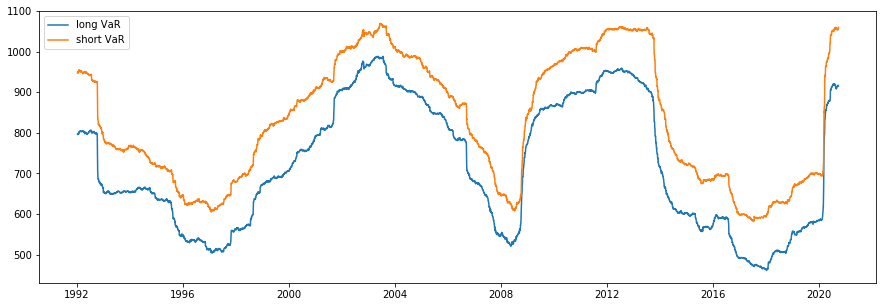

In [211]:
aa.parametric()

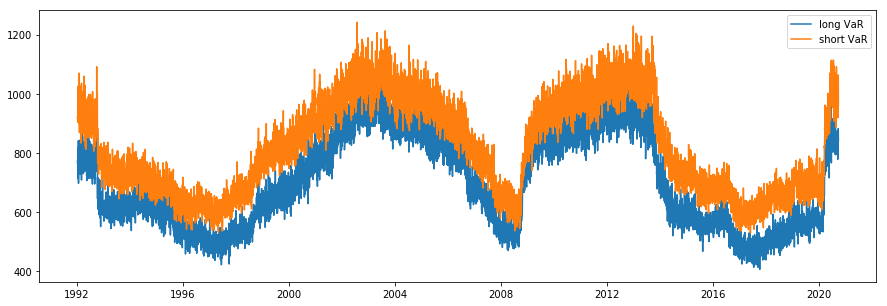

In [213]:
aa.Monte_Carlo()

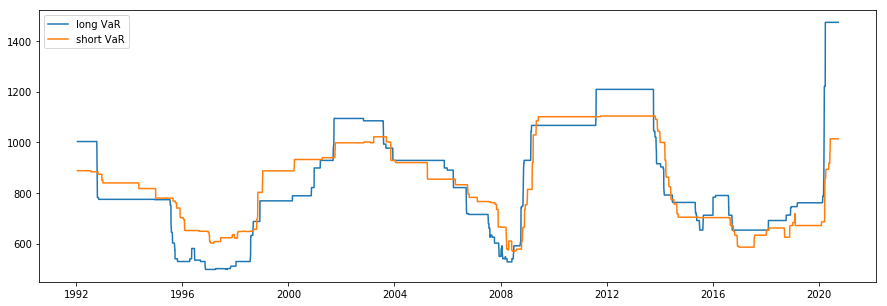

In [214]:
aa.historical()

In [225]:
start_date = '1987-01-16'
end_date = '2020-09-30'
data = web.DataReader(name='aapl', data_source='yahoo',start=start_date, end= end_date)
data = data.reset_index()

In [ ]:
## draft    

In [4]:
stocks = ['msft','ba','jnj','ge','dis']
share_ratio = [10,5,10,5,8]
start_date = '1987-01-16'
end_date = '2020-09-30'
stocks_df = []
for stock in stocks:
    data = web.DataReader(name=stock, data_source='yahoo',start=start_date, end= end_date)
    data = data.reset_index()
    stocks_df.append(data)

In [20]:
bb = [data_preprocess(stock['Adj Close'],5) for stock, ratio in zip(stocks_df, share_ratio)]

In [24]:
len(bb[0])

3

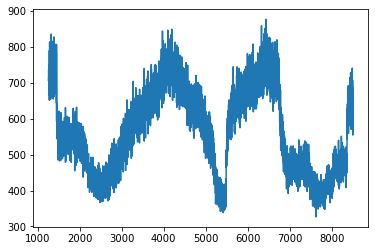

In [168]:
plt.plot(VaR_long)

In [142]:
loss = 10000 - sum(stocks_simu)

In [150]:
p = [np.percentile(l,99,interpolation = 'lower') for l in loss]

In [152]:
p[-1]

647.3741575233253

In [543]:
shares_multi = v0/sum([stock["Adj Close"]*w for stock, w in zip(stocks_df, share_ratio)])

sigma_list = []
mu_list = []
log_return_list = []
stock_v_list = []
Ev_i = []
Ev_i_2 = []
share_list = []
for stock, ratio in zip(stocks_df, share_ratio):
    
    price = stock['Adj Close']
    
    sigma, mu, log_return = data_preprocess(price,5)
    sigma_list.append(sigma)
    mu_list.append(mu)
    log_return_list.append(log_return)
    
    share = ratio*shares_multi
    share_list.append(share)
    
    stock_v = share*price
    stock_v_list.append(stock_v)
    
    Ev_i.append(stock_v*np.exp(mu*5/252))
    Ev_i_2.append(stock_v**2*np.exp((2*mu+sigma**2)*5/252))
    


In [551]:
returns = pd.DataFrame(log_return_list).T
corr_matrix = returns.rolling(window*252).corr()
corr_m = np.array([np.matrix(corr_matrix.loc[n,:]) for n in range(0,len(stocks_df[0]))])

Eij_list = []
for i in range(0,len(stocks_df)):
    for j in range(i+1,len(stocks_df)):
        print(i,j)
        corr = [corr_m[n][i][j] for n in range(0,len(corr_m))]
        
        Eij =  2*stock_v_list[i]*stock_v_list[j]*np.exp((mu_list[i]+mu_list[j]+sigma_list[i]*sigma_list[j]*corr)*5/252)
        Eij_list.append(Eij)    

0 1


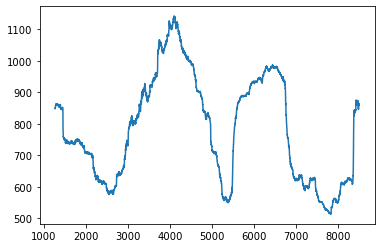

In [560]:
EV = sum(Ev_i)
EV_2 = sum(Eij_list) + sum(Ev_i_2)
var = EV_2 - EV**2
VaR = v0- (EV + norm.ppf(1-0.99)*var**0.5)
plt.plot(VaR)

In [ ]:
def distribution_step_2(stock_values, mu, sigma, corr):
    v_i = []
    v_i_2 = []
    for i,j,k in zip(stock_values,mu,sigma):
        v_i.append(i*np.exp(j*5/252))
        v_i_2.append(i**2*np.exp((2*j+k**2)*5/252))
        
    

In [308]:
def distribution(stocks_df, share_ratio):
    sigma_list = []
    mu_list = []
    log_return_list = []
    stock_v_list = []
    for stock, ratio in zip(stocks_df, share_ratio):
        price = stock['Adj Close']
        sigma, mu, log_return = data_preprocess(price,5)
        sigma_list.append(sigma)
        mu_list.append(mu)
        log_return_list.append(log_return)
        share = ratio*shares_multi
        stock_v = share*price
        stock_v_list.append(stock_v)
    
    
    
    

0       10000.0
1       10000.0
2       10000.0
3       10000.0
4       10000.0
         ...   
8491    10000.0
8492    10000.0
8493    10000.0
8494    10000.0
8495    10000.0
Name: Adj Close, Length: 8496, dtype: float64

In [158]:
v0 = 10000
VaR_P = 0.99 
risk_day = 5


## portfolio
price = sum([stock["Adj Close"]*ratio for stock, ratio in zip(stocks_df,share_ratio)])


In [167]:
## log return

log_return = np.log(price/price.shift(1))

## log return**2

log_return_sq = log_return**2

## ma sd of log return
## ma
window = 5
#if exponential = 1:
#    ma = log_return.ewm(alpha = 0.05,min_periods=window).mean()
#else:
delta_t = 1/252
ma = log_return.rolling(window*252).mean() ## daily log return moving average
variance = log_return_sq.rolling(window*252).mean() - ma**2 #daily log return variance
sd = variance**0.5  #daily log return variance
sigma = sd/(delta_t)**0.5   #yearly
mu = ma/delta_t + (sigma**2)/2  #yearly

In [168]:
#VaR
shares = v0/price
value_0 = shares*price
value_t_long = shares*price * np.exp(sigma* ((risk_day/252)**0.5) * norm.ppf(1-VaR_P) + (mu - sigma**2/2)*(risk_day/252))
value_t_short = shares*price * np.exp(sigma* ((risk_day/252)**0.5) * norm.ppf(VaR_P) + (mu - sigma**2/2)*(risk_day/252))

long_VaR = value_0 - value_t_long
short_VaR = value_0 - (value_0 + value_0 - value_t_short)

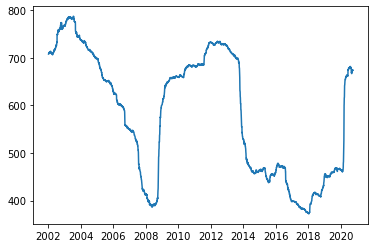

In [189]:
plt.plot(stocks_df[0]['Date'][15*252:],long_VaR[15*252:])

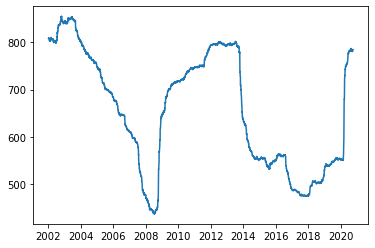

In [191]:
plt.plot(stocks_df[0]['Date'][15*252:],short_VaR[15*252:])

## portfolio GBM

In [250]:
stocks_df

[           Date        High         Low        Open       Close       Volume  \
 0    1987-01-16    0.219618    0.210069    0.219618    0.214410   65433600.0   
 1    1987-01-19    0.222222    0.210069    0.214410    0.222222   88243200.0   
 2    1987-01-20    0.230903    0.221354    0.222222    0.225694   95760000.0   
 3    1987-01-21    0.241319    0.221354    0.225694    0.235243  108489600.0   
 4    1987-01-22    0.259549    0.228299    0.235243    0.258681  116035200.0   
 ...         ...         ...         ...         ...         ...          ...   
 8491 2020-09-24  205.570007  199.199997  199.850006  203.190002   31202500.0   
 8492 2020-09-25  209.039993  202.539993  203.550003  207.820007   29437300.0   
 8493 2020-09-28  212.570007  208.059998  210.880005  209.440002   32004900.0   
 8494 2020-09-29  210.070007  206.809998  209.350006  207.259995   24221900.0   
 8495 2020-09-30  211.979996  206.539993  207.729996  210.330002   33829100.0   
 
        Adj Close  
 0    